# **Week11 Homework 1 - Diffusion Model**

Goal: build a diffusion Model for anime face generation.


## Set up the environment


### Packages Installation

In [ ]:
# You may replace the workspace directory if you want.
workspace_dir = '.'

# Training progress bar
!pip install -q qqdm

!pip install animeface

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 114.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 30.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.5/133.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 71.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.29.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8

### Download the dataset

In [ ]:
!gdown --id '1PCySpHM69xk-DZG32L9MjvNUsR1JbjHM' --output "crypko_data.zip"

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Failed to retrieve file url:

	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator.

You may still be able to access the file from the browser:

	https://drive.google.com/uc?id=1PCySpHM69xk-DZG32L9MjvNUsR1JbjHM

but Gdown can't. Please check connections and permissions.


###Unzip the downloaded file.
The unzipped tree structure is like
```
faces/
├── 1.jpg
├── 2.jpg
├── 3.jpg
...
```

In [ ]:
!unzip -q "crypko_data.zip" -d "./"

## Random seed
Set the random seed to a certain value for reproducibility.

In [ ]:
import random

import torch
import numpy as np


def same_seeds(seed):
    # Python built-in random module
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Torch
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2023)

## Import Packages
First, we need to import packages that will be used later.

We highly rely on **torchvision**, a library of PyTorch.

In [ ]:
import os
import glob

import math
from functools import partial, wraps

import torch
from torch import sqrt
from torch import nn, einsum
import torch.nn.functional as F
from torch.special import expm1
from torch.amp import autocast
from torch import optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange
import matplotlib.pyplot as plt
from qqdm.notebook import qqdm

## Dataset
1. Resize the images to (64, 64)
1. Linearly map the values from [0, 1] to  [-1, 1].

Please refer to [PyTorch official website](https://pytorch.org/vision/stable/transforms.html) for details about different transforms.


In [ ]:
class CrypkoDataset(Dataset):
    def __init__(self, fnames, transform):
        self.transform = transform
        self.fnames = fnames
        self.num_samples = len(self.fnames)

    def __getitem__(self,idx):
        fname = self.fnames[idx]
        # 1. Load the image
        img = torchvision.io.read_image(fname)
        # 2. Resize and normalize the images using torchvision.
        img = self.transform(img)
        return img

    def __len__(self):
        return self.num_samples


def get_dataset(root):
    fnames = glob.glob(os.path.join(root, '*'))
    # 1. Resize the image to (64, 64)
    # 2. Linearly map [0, 1] to [-1, 1]
    compose = [
        transforms.ToPILImage(),
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ]
    transform = transforms.Compose(compose)
    dataset = CrypkoDataset(fnames, transform)
    return dataset

### Show some images
Note that the values are in the range of [-1, 1], we should shift them to the valid range, [0, 1], to display correctly.

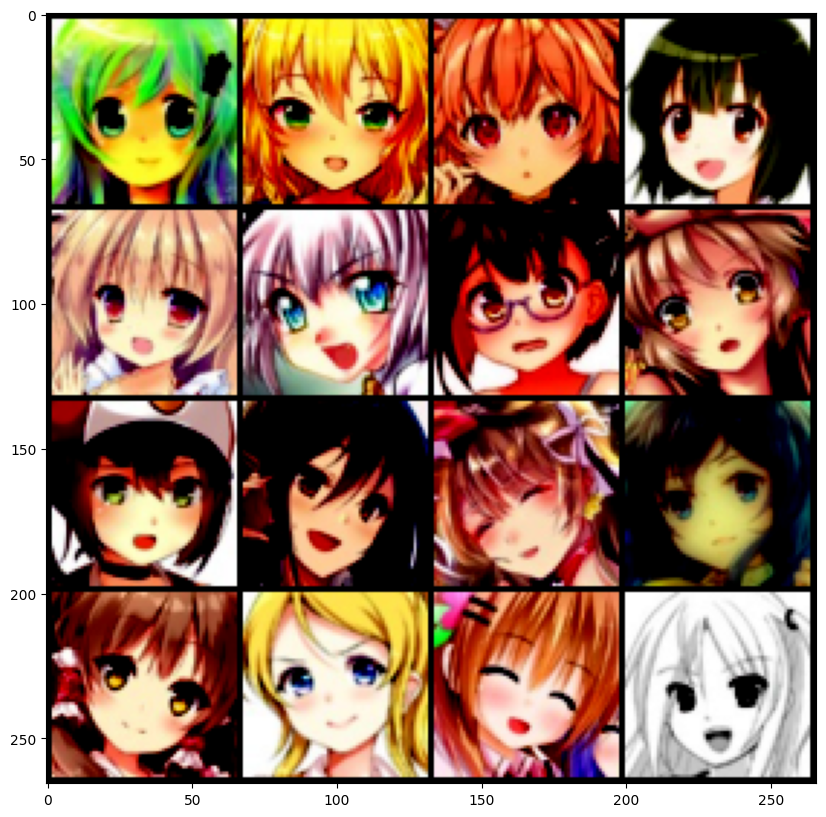

In [ ]:
dataset = get_dataset(os.path.join(workspace_dir, 'faces'))

images = [dataset[i] for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

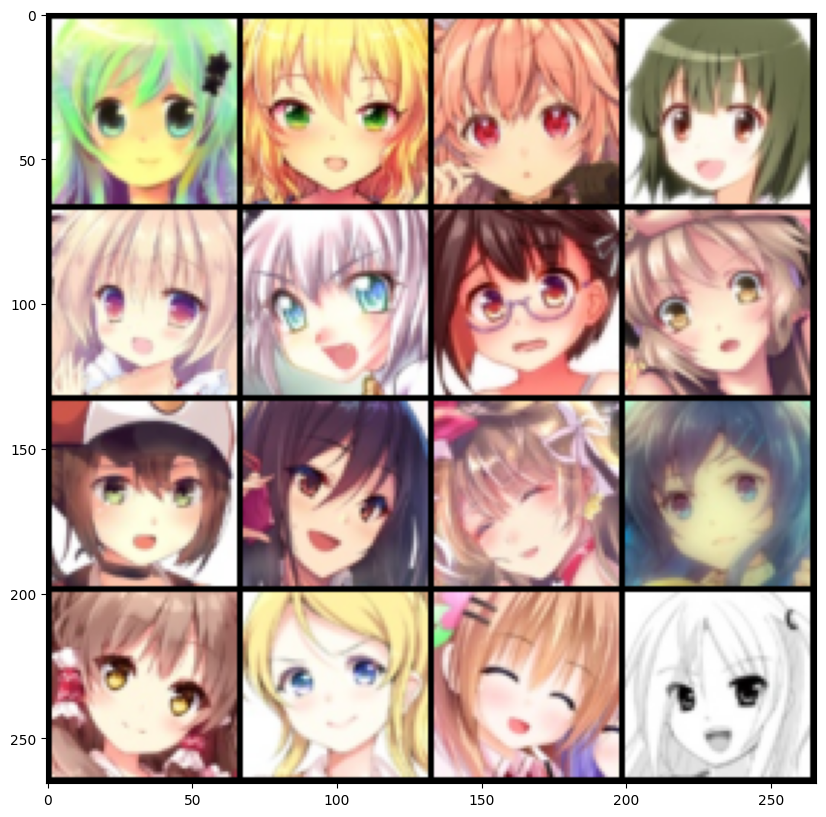

In [ ]:
images = [(dataset[i]+1)/2 for i in range(16)]
grid_img = torchvision.utils.make_grid(images, nrow=4)
plt.figure(figsize=(10,10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.show()

## Model
Here, we use a Simple Diffusion Model as the model structure.
This part of the code is directly from this [repository](https://github.com/lucidrains/denoising-diffusion-pytorch/blob/main/denoising_diffusion_pytorch/simple_diffusion.py).
Feel free to modify your own model structure or use more advanced models.

In [ ]:
import math
from functools import partial, wraps

import torch
from torch import sqrt
from torch import nn, einsum
import torch.nn.functional as F
from torch.special import expm1
from torch.amp import autocast

from tqdm import tqdm
from einops import rearrange, repeat, reduce, pack, unpack
from einops.layers.torch import Rearrange

# helpers

def exists(val):
    return val is not None

def identity(t):
    return t

def is_lambda(f):
    return callable(f) and f.__name__ == "<lambda>"

def default(val, d):
    if exists(val):
        return val
    return d() if is_lambda(d) else d

def cast_tuple(t, l = 1):
    return ((t,) * l) if not isinstance(t, tuple) else t

def append_dims(t, dims):
    shape = t.shape
    return t.reshape(*shape, *((1,) * dims))

def l2norm(t):
    return F.normalize(t, dim = -1)

# u-vit related functions and modules

class Upsample(nn.Module):
    def __init__(
        self,
        dim,
        dim_out = None,
        factor = 2
    ):
        super().__init__()
        self.factor = factor
        self.factor_squared = factor ** 2

        dim_out = default(dim_out, dim)
        conv = nn.Conv2d(dim, dim_out * self.factor_squared, 1)

        self.net = nn.Sequential(
            conv,
            nn.SiLU(),
            nn.PixelShuffle(factor)
        )

        self.init_conv_(conv)

    def init_conv_(self, conv):
        o, i, h, w = conv.weight.shape
        conv_weight = torch.empty(o // self.factor_squared, i, h, w)
        nn.init.kaiming_uniform_(conv_weight)
        conv_weight = repeat(conv_weight, 'o ... -> (o r) ...', r = self.factor_squared)

        conv.weight.data.copy_(conv_weight)
        nn.init.zeros_(conv.bias.data)

    def forward(self, x):
        return self.net(x)

def Downsample(
    dim,
    dim_out = None,
    factor = 2
):
    return nn.Sequential(
        Rearrange('b c (h p1) (w p2) -> b (c p1 p2) h w', p1 = factor, p2 = factor),
        nn.Conv2d(dim * (factor ** 2), default(dim_out, dim), 1)
    )

class RMSNorm(nn.Module):
    def __init__(self, dim, scale = True, normalize_dim = 2):
        super().__init__()
        self.g = nn.Parameter(torch.ones(dim)) if scale else 1

        self.scale = scale
        self.normalize_dim = normalize_dim

    def forward(self, x):
        normalize_dim = self.normalize_dim
        scale = append_dims(self.g, x.ndim - self.normalize_dim - 1) if self.scale else 1
        return F.normalize(x, dim = normalize_dim) * scale * (x.shape[normalize_dim] ** 0.5)

# sinusoidal positional embeds

class LearnedSinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        assert (dim % 2) == 0
        half_dim = dim // 2
        self.weights = nn.Parameter(torch.randn(half_dim))

    def forward(self, x):
        x = rearrange(x, 'b -> b 1')
        freqs = x * rearrange(self.weights, 'd -> 1 d') * 2 * math.pi
        fouriered = torch.cat((freqs.sin(), freqs.cos()), dim = -1)
        fouriered = torch.cat((x, fouriered), dim = -1)
        return fouriered

# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = RMSNorm(dim_out, normalize_dim = 1)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out * 2)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out)
        self.block2 = Block(dim_out, dim_out)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb.chunk(2, dim = 1)

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32):
        super().__init__()
        self.scale = dim_head ** -0.5
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim, normalize_dim = 1)
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias = False)

        self.to_out = nn.Sequential(
            nn.Conv2d(hidden_dim, dim, 1),
            RMSNorm(dim, normalize_dim = 1)
        )

    def forward(self, x):
        residual = x

        b, c, h, w = x.shape

        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h c) x y -> b h c (x y)', h = self.heads), qkv)

        q = q.softmax(dim = -2)
        k = k.softmax(dim = -1)

        q = q * self.scale

        context = torch.einsum('b h d n, b h e n -> b h d e', k, v)

        out = torch.einsum('b h d e, b h d n -> b h e n', context, q)
        out = rearrange(out, 'b h c (x y) -> b (h c) x y', h = self.heads, x = h, y = w)

        return self.to_out(out) + residual

class Attention(nn.Module):
    def __init__(self, dim, heads = 4, dim_head = 32, scale = 8, dropout = 0.):
        super().__init__()
        self.scale = scale
        self.heads = heads
        hidden_dim = dim_head * heads

        self.norm = RMSNorm(dim)

        self.attn_dropout = nn.Dropout(dropout)
        self.to_qkv = nn.Linear(dim, hidden_dim * 3, bias = False)

        self.q_scale = nn.Parameter(torch.ones(dim_head))
        self.k_scale = nn.Parameter(torch.ones(dim_head))

        self.to_out = nn.Linear(hidden_dim, dim, bias = False)

    def forward(self, x):
        x = self.norm(x)

        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = self.heads), qkv)

        q, k = map(l2norm, (q, k))

        q = q * self.q_scale
        k = k * self.k_scale

        sim = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = sim.softmax(dim = -1)
        attn = self.attn_dropout(attn)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)

        out = rearrange(out, 'b h n d -> b n (h d)')
        return self.to_out(out)

class FeedForward(nn.Module):
    def __init__(
        self,
        dim,
        cond_dim,
        mult = 4,
        dropout = 0.
    ):
        super().__init__()
        self.norm = RMSNorm(dim, scale = False)
        dim_hidden = dim * mult

        self.to_scale_shift = nn.Sequential(
            nn.SiLU(),
            nn.Linear(cond_dim, dim_hidden * 2),
            Rearrange('b d -> b 1 d')
        )

        to_scale_shift_linear = self.to_scale_shift[-2]
        nn.init.zeros_(to_scale_shift_linear.weight)
        nn.init.zeros_(to_scale_shift_linear.bias)

        self.proj_in = nn.Sequential(
            nn.Linear(dim, dim_hidden, bias = False),
            nn.SiLU()
        )

        self.proj_out = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(dim_hidden, dim, bias = False)
        )

    def forward(self, x, t):
        x = self.norm(x)
        x = self.proj_in(x)

        scale, shift = self.to_scale_shift(t).chunk(2, dim = -1)
        x = x * (scale + 1) + shift

        return self.proj_out(x)

# vit

class Transformer(nn.Module):
    def __init__(
        self,
        dim,
        time_cond_dim,
        depth,
        dim_head = 32,
        heads = 4,
        ff_mult = 4,
        dropout = 0.,
    ):
        super().__init__()

        self.layers = nn.ModuleList([])
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                Attention(dim = dim, dim_head = dim_head, heads = heads, dropout = dropout),
                FeedForward(dim = dim, mult = ff_mult, cond_dim = time_cond_dim, dropout = dropout)
            ]))

    def forward(self, x, t):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x, t) + x

        return x
# model

class UViT(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults = (1, 2, 4, 8),
        downsample_factor = 2,
        channels = 3,
        vit_depth = 6,
        vit_dropout = 0.2,
        attn_dim_head = 32,
        attn_heads = 4,
        ff_mult = 4,
        learned_sinusoidal_dim = 16,
        init_img_transform: callable = None,
        final_img_itransform: callable = None,
        patch_size = 1,
        dual_patchnorm = False
    ):
        super().__init__()

        # for initial dwt transform (or whatever transform researcher wants to try here)

        if exists(init_img_transform) and exists(final_img_itransform):
            init_shape = torch.Size(1, 1, 32, 32)
            mock_tensor = torch.randn(init_shape)
            assert final_img_itransform(init_img_transform(mock_tensor)).shape == init_shape

        self.init_img_transform = default(init_img_transform, identity)
        self.final_img_itransform = default(final_img_itransform, identity)

        input_channels = channels

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        # whether to do initial patching, as alternative to dwt

        self.unpatchify = identity

        input_channels = channels * (patch_size ** 2)
        needs_patch = patch_size > 1

        if needs_patch:
            if not dual_patchnorm:
                self.init_conv = nn.Conv2d(channels, init_dim, patch_size, stride = patch_size)
            else:
                self.init_conv = nn.Sequential(
                    Rearrange('b c (h p1) (w p2) -> b h w (c p1 p2)', p1 = patch_size, p2 = patch_size),
                    nn.LayerNorm(input_channels),
                    nn.Linear(input_channels, init_dim),
                    nn.LayerNorm(init_dim),
                    Rearrange('b h w c -> b c h w')
                )

            self.unpatchify = nn.ConvTranspose2d(input_channels, channels, patch_size, stride = patch_size)

        # determine dimensions

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        # time embeddings

        time_dim = dim * 4

        sinu_pos_emb = LearnedSinusoidalPosEmb(learned_sinusoidal_dim)
        fourier_dim = learned_sinusoidal_dim + 1

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # downsample factors

        downsample_factor = cast_tuple(downsample_factor, len(dim_mults))
        assert len(downsample_factor) == len(dim_mults)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, ((dim_in, dim_out), factor) in enumerate(zip(in_out, downsample_factor)):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(nn.ModuleList([
                ResnetBlock(dim_in, dim_in, time_emb_dim = time_dim),
                ResnetBlock(dim_in, dim_in, time_emb_dim = time_dim),
                LinearAttention(dim_in),
                Downsample(dim_in, dim_out, factor = factor)
            ]))

        mid_dim = dims[-1]

        self.vit = Transformer(
            dim = mid_dim,
            time_cond_dim = time_dim,
            depth = vit_depth,
            dim_head = attn_dim_head,
            heads = attn_heads,
            ff_mult = ff_mult,
            dropout = vit_dropout
        )

        for ind, ((dim_in, dim_out), factor) in enumerate(zip(reversed(in_out), reversed(downsample_factor))):
            is_last = ind == (len(in_out) - 1)

            self.ups.append(nn.ModuleList([
                Upsample(dim_out, dim_in, factor = factor),
                ResnetBlock(dim_in * 2, dim_in, time_emb_dim = time_dim),
                ResnetBlock(dim_in * 2, dim_in, time_emb_dim = time_dim),
                LinearAttention(dim_in),
            ]))

        default_out_dim = input_channels
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = ResnetBlock(init_dim * 2, init_dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(init_dim, self.out_dim, 1)

    def forward(self, x, time):
        x = self.init_img_transform(x)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x)
            h.append(x)

            x = downsample(x)

        x = rearrange(x, 'b c h w -> b h w c')
        x, ps = pack([x], 'b * c')

        x = self.vit(x, t)

        x, = unpack(x, ps, 'b * c')
        x = rearrange(x, 'b h w c -> b c h w')

        for upsample, block1, block2, attn in self.ups:
            x = upsample(x)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        x = self.final_conv(x)

        x = self.unpatchify(x)
        return self.final_img_itransform(x)

# normalization functions

def normalize_to_neg_one_to_one(img):
    return img * 2 - 1

def unnormalize_to_zero_to_one(t):
    return (t + 1) * 0.5

# diffusion helpers

def right_pad_dims_to(x, t):
    padding_dims = x.ndim - t.ndim
    if padding_dims <= 0:
        return t
    return t.view(*t.shape, *((1,) * padding_dims))

# logsnr schedules and shifting / interpolating decorators
# only cosine for now

def log(t, eps = 1e-20):
    return torch.log(t.clamp(min = eps))

def logsnr_schedule_cosine(t, logsnr_min = -15, logsnr_max = 15):
    t_min = math.atan(math.exp(-0.5 * logsnr_max))
    t_max = math.atan(math.exp(-0.5 * logsnr_min))
    return -2 * log(torch.tan(t_min + t * (t_max - t_min)))

def logsnr_schedule_shifted(fn, image_d, noise_d):
    shift = 2 * math.log(noise_d / image_d)
    @wraps(fn)
    def inner(*args, **kwargs):
        nonlocal shift
        return fn(*args, **kwargs) + shift
    return inner

def logsnr_schedule_interpolated(fn, image_d, noise_d_low, noise_d_high):
    logsnr_low_fn = logsnr_schedule_shifted(fn, image_d, noise_d_low)
    logsnr_high_fn = logsnr_schedule_shifted(fn, image_d, noise_d_high)

    @wraps(fn)
    def inner(t, *args, **kwargs):
        nonlocal logsnr_low_fn
        nonlocal logsnr_high_fn
        return t * logsnr_low_fn(t, *args, **kwargs) + (1 - t) * logsnr_high_fn(t, *args, **kwargs)

    return inner

# main gaussian diffusion class

class GaussianDiffusion(nn.Module):
    def __init__(
        self,
        model: UViT,
        *,
        image_size,
        channels = 3,
        pred_objective = 'v',
        noise_schedule = logsnr_schedule_cosine,
        noise_d = None,
        noise_d_low = None,
        noise_d_high = None,
        num_sample_steps = 500,
        clip_sample_denoised = True,
        min_snr_loss_weight = True,
        min_snr_gamma = 5
    ):
        super().__init__()
        assert pred_objective in {'v', 'eps'}, 'whether to predict v-space (progressive distillation paper) or noise'

        self.model = model

        # image dimensions

        self.channels = channels
        self.image_size = image_size

        # training objective

        self.pred_objective = pred_objective

        # noise schedule

        assert not all([*map(exists, (noise_d, noise_d_low, noise_d_high))]), 'you must either set noise_d for shifted schedule, or noise_d_low and noise_d_high for shifted and interpolated schedule'

        # determine shifting or interpolated schedules

        self.log_snr = noise_schedule

        if exists(noise_d):
            self.log_snr = logsnr_schedule_shifted(self.log_snr, image_size, noise_d)

        if exists(noise_d_low) or exists(noise_d_high):
            assert exists(noise_d_low) and exists(noise_d_high), 'both noise_d_low and noise_d_high must be set'

            self.log_snr = logsnr_schedule_interpolated(self.log_snr, image_size, noise_d_low, noise_d_high)

        # sampling

        self.num_sample_steps = num_sample_steps
        self.clip_sample_denoised = clip_sample_denoised

        # loss weight

        self.min_snr_loss_weight = min_snr_loss_weight
        self.min_snr_gamma = min_snr_gamma

    @property
    def device(self):
        return next(self.model.parameters()).device

    def p_mean_variance(self, x, time, time_next):

        log_snr = self.log_snr(time)
        log_snr_next = self.log_snr(time_next)
        c = -expm1(log_snr - log_snr_next)

        squared_alpha, squared_alpha_next = log_snr.sigmoid(), log_snr_next.sigmoid()
        squared_sigma, squared_sigma_next = (-log_snr).sigmoid(), (-log_snr_next).sigmoid()

        alpha, sigma, alpha_next = map(sqrt, (squared_alpha, squared_sigma, squared_alpha_next))

        batch_log_snr = repeat(log_snr, ' -> b', b = x.shape[0])
        pred = self.model(x, batch_log_snr)

        if self.pred_objective == 'v':
            x_start = alpha * x - sigma * pred

        elif self.pred_objective == 'eps':
            x_start = (x - sigma * pred) / alpha

        x_start.clamp_(-1., 1.)

        model_mean = alpha_next * (x * (1 - c) / alpha + c * x_start)

        posterior_variance = squared_sigma_next * c

        return model_mean, posterior_variance

    # sampling related functions

    @torch.no_grad()
    def p_sample(self, x, time, time_next):
        batch, *_, device = *x.shape, x.device

        model_mean, model_variance = self.p_mean_variance(x = x, time = time, time_next = time_next)

        if time_next == 0:
            return model_mean

        noise = torch.randn_like(x)
        return model_mean + sqrt(model_variance) * noise

    @torch.no_grad()
    def p_sample_loop(self, shape):
        batch = shape[0]

        img = torch.randn(shape, device = self.device)
        steps = torch.linspace(1., 0., self.num_sample_steps + 1, device = self.device)

        for i in tqdm(range(self.num_sample_steps), desc = 'sampling loop time step', total = self.num_sample_steps):
            times = steps[i]
            times_next = steps[i + 1]
            img = self.p_sample(img, times, times_next)

        img.clamp_(-1., 1.)
        img = unnormalize_to_zero_to_one(img)
        return img

    @torch.no_grad()
    def sample(self, batch_size = 16):
        return self.p_sample_loop((batch_size, self.channels, self.image_size, self.image_size))

    # training related functions - noise prediction

    @autocast('cuda', enabled = False)
    def q_sample(self, x_start, times, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        log_snr = self.log_snr(times)

        log_snr_padded = right_pad_dims_to(x_start, log_snr)
        alpha, sigma = sqrt(log_snr_padded.sigmoid()), sqrt((-log_snr_padded).sigmoid())
        x_noised =  x_start * alpha + noise * sigma

        return x_noised, log_snr

    def p_losses(self, x_start, times, noise = None):
        noise = default(noise, lambda: torch.randn_like(x_start))

        x, log_snr = self.q_sample(x_start = x_start, times = times, noise = noise)
        model_out = self.model(x, log_snr)

        if self.pred_objective == 'v':
            padded_log_snr = right_pad_dims_to(x, log_snr)
            alpha, sigma = padded_log_snr.sigmoid().sqrt(), (-padded_log_snr).sigmoid().sqrt()
            target = alpha * noise - sigma * x_start

        elif self.pred_objective == 'eps':
            target = noise

        loss = F.mse_loss(model_out, target, reduction = 'none')

        loss = reduce(loss, 'b ... -> b', 'mean')

        snr = log_snr.exp()

        maybe_clip_snr = snr.clone()
        if self.min_snr_loss_weight:
            maybe_clip_snr.clamp_(max = self.min_snr_gamma)

        if self.pred_objective == 'v':
            loss_weight = maybe_clip_snr / (snr + 1)

        elif self.pred_objective == 'eps':
            loss_weight = maybe_clip_snr / snr

        return (loss * loss_weight).mean()

    def forward(self, img, *args, **kwargs):
        b, c, h, w, device, img_size, = *img.shape, img.device, self.image_size
        assert h == img_size and w == img_size, f'height and width of image must be {img_size}'

        img = normalize_to_neg_one_to_one(img)
        times = torch.zeros((img.shape[0],), device = self.device).float().uniform_(0, 1)

        return self.p_losses(img, times, *args, **kwargs)

## Training

In [ ]:
import os
import torch
from torch.utils.data import DataLoader
from tqdm import tqdm

# Training hyperparameters
batch_size = 64
lr = 1e-4
n_epoch = 3  # Adjust as needed

# Directories for logging and checkpoints
log_dir = os.path.join(workspace_dir, 'logs')
ckpt_dir = os.path.join(workspace_dir, 'checkpoints')
os.makedirs(log_dir, exist_ok=True)
os.makedirs(ckpt_dir, exist_ok=True)

# Initialize the model and diffusion process
image_size = 32
channels = 3
dim = 64

# Initialize UViT and GaussianDiffusion model
uvit_model = UViT(
    dim=dim,
    channels=channels,
    init_dim=None,
    out_dim=None,
    dim_mults=(1, 2, 4, 8),
    vit_depth=6,
    attn_dim_head=32,
    attn_heads=4,
    ff_mult=4,
    learned_sinusoidal_dim=16
).cuda()

diffusion_model = GaussianDiffusion(
    model=uvit_model,
    image_size=64,
    channels=channels,
    num_sample_steps=500
).cuda()

# Optimizer
optimizer = torch.optim.Adam(diffusion_model.parameters(), lr=lr)

# DataLoader (assuming 'dataset' is defined elsewhere)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Training loop
for epoch in range(n_epoch):
    epoch_loss = 0
    for img in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epoch}"):
        img = img.cuda()

        # Zero out the gradients
        optimizer.zero_grad()

        # Forward pass through the diffusion model for loss calculation
        loss = diffusion_model(img)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    avg_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch+1}/{n_epoch}], Loss: {avg_loss:.4f}")

    # Save model checkpoint
    if (epoch + 1) % 1 == 0 or epoch == n_epoch - 1:  # Save at every epoch for demonstration
        torch.save(diffusion_model.state_dict(), os.path.join(ckpt_dir, f"diffusion_epoch_{epoch+1}.pth"))

print("Training completed.")


Epoch 1/3: 100%|██████████| 1115/1115 [13:32<00:00,  1.37it/s]


Epoch [1/3], Loss: 0.0661


Epoch 2/3: 100%|██████████| 1115/1115 [13:29<00:00,  1.38it/s]


Epoch [2/3], Loss: 0.0438


Epoch 3/3: 100%|██████████| 1115/1115 [13:28<00:00,  1.38it/s]


Epoch [3/3], Loss: 0.0395
Training completed.


### Load model

<ipython-input-42-d16b1127b639>:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  diffusion_model.load_state_dict(torch.load(checkpoint_path))
sampling loop time step: 100%|█

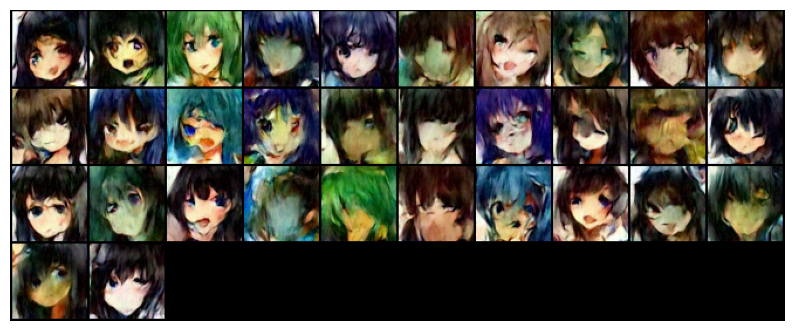

In [ ]:
# Load the trained diffusion model
channels = 3
image_size = 64

# Load the model checkpoint and set it to evaluation mode
checkpoint_path = os.path.join(ckpt_dir, 'diffusion_epoch_3.pth')
diffusion_model.load_state_dict(torch.load(checkpoint_path))
diffusion_model.eval()

# Generate images
n_output = 100
generated_images = diffusion_model.sample(batch_size=n_output)  # Generates n_output images

# Save the generated images as a grid
filename = os.path.join(log_dir, 'result.jpg')
torchvision.utils.save_image(generated_images, filename, nrow=10)

# Display a subset of generated images (32 images)
grid_img = torchvision.utils.make_grid(generated_images[:32].cpu(), nrow=10)
plt.figure(figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()


### Compress the generated images using **tar**.


In [ ]:
# Save the generated images.
os.makedirs('output', exist_ok=True)
for i in range(100):
    torchvision.utils.save_image(generated_images[i], f'output/{i+1}.jpg')

# Compress the images.
%cd output
!tar -zcf ../images.tgz *.jpg
%cd ..

/content/output
/content
